# 1. 读取

In [1]:
import pandas as pd
from cyvcf2 import VCF, Writer
import subprocess
import os
import random

# 1. 定义路径
VCF2DIS = "/home/qmtang/GitHub/VCF2Dis/bin/VCF2Dis"
KGP_vcf = "/mnt/qmtang/EvoFill_data/20251121_chr22_v2/chr22_trimmed_1kGP.vcf.gz"
KGP_ped = "/mnt/NAS/Omics/DNA/1kGP/meta/20130606_g1k.ped"
save_dir = "/mnt/qmtang/EvoFill_data/20251121_chr22_v2/"

def setup_workdir(save_dir, ) -> None:
    """Create necessary directories"""
    sub_dir = ["models", "pretrain", "augment", "finetune", "impute_in", "impute_out"]
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    for dd in sub_dir:
        if not os.path.exists(f"{save_dir}/{dd}"):
            os.makedirs(f"{save_dir}/{dd}")
setup_workdir(save_dir)

pop_anno = {
    "GWD":  {"中文":"冈比亚西部人",        "地区":"非洲/冈比亚",            "说明":"西非撒哈拉以南，班图语支"},
    "CHS":  {"中文":"中国南方汉族",        "地区":"亚洲/中国南方",         "说明":"中国汉族南方群体"},
    "TSI":  {"中文":"托斯卡纳人",          "地区":"欧洲/意大利",           "说明":"意大利中部托斯卡纳地区"},
    "PUR":  {"中文":"波多黎各人",          "地区":"美洲/波多黎各",         "说明":"拉丁裔，欧洲-非洲-美洲土著混合"},
    "JPT":  {"中文":"日本东京人",          "地区":"亚洲/日本",             "说明":"本州岛东部，大和族"},
    "IBS":  {"中文":"西班牙伊比利亚人",    "地区":"欧洲/西班牙",           "说明":"伊比利亚半岛土著"},
    "YRI":  {"中文":"尼日利亚约鲁巴人",    "地区":"非洲/尼日利亚",         "说明":"西非尼日尔-刚果语系"},
    "GIH":  {"中文":"印度古吉拉特人",      "地区":"亚洲/印度（古吉拉特）", "说明":"印度西部，印欧语系"},
    "FIN":  {"中文":"芬兰人",              "地区":"欧洲/芬兰",             "说明":"北欧乌拉尔语系，遗传瓶颈明显"},
    "CEU":  {"中文":"北欧白人（犹他）",    "地区":"欧洲/西北欧→美国",      "说明":"西北欧移民后裔（美国犹他州）"},
    "ITU":  {"中文":"印度泰卢固人",        "地区":"亚洲/印度（安得拉）",   "说明":"印度东南部，德拉维语系"},
    "STU":  {"中文":"印度泰米尔人",        "地区":"亚洲/印度（泰米尔纳德）","说明":"印度最南端，德拉维语系"},
    "KHV":  {"中文":"越南京族人",          "地区":"亚洲/越南",             "说明":"越南北部，南亚语系→越芒语支"},
    "CHB":  {"中文":"中国北方汉族",        "地区":"亚洲/中国北方",         "说明":"中国汉族北方群体"},
    "LWK":  {"中文":"肯尼亚卢赫雅人",      "地区":"非洲/肯尼亚",           "说明":"东非班图语支"},
    "ESN":  {"中文":"尼日利亚埃桑人",      "地区":"非洲/尼日利亚",         "说明":"尼日尔-刚果语系，西非"},
    "ACB":  {"中文":"加勒比非裔",          "地区":"美洲/加勒比→非洲",      "说明":"非洲奴隶贸易后裔（加勒比地区）"},
    "PJL":  {"中文":"印度旁遮普人",        "地区":"亚洲/印度（旁遮普）",   "说明":"印度西北部，印欧语系"},
    "GBR":  {"中文":"英国英格兰人",        "地区":"欧洲/英国",             "说明":"大不列颠岛土著"},
    "CLM":  {"中文":"哥伦比亚麦德林人",    "地区":"美洲/哥伦比亚",         "说明":"拉丁裔，欧洲-美洲土著-非洲混合"},
    "CDX":  {"中文":"中国西双版纳傣族人",  "地区":"亚洲/中国云南",         "说明":"傣泰民族，侗台语系"},
    "MSL":  {"中文":"塞拉利昂门德人",      "地区":"非洲/塞拉利昂",         "说明":"西非曼德语支"},
    "PEL":  {"中文":"秘鲁利马人",          "地区":"美洲/秘鲁",             "说明":"拉丁裔，克丘亚-欧洲混合"},
    "BEB":  {"中文":"孟加拉国人",          "地区":"亚洲/孟加拉国",         "说明":"孟加拉湾沿岸，印欧语系"},
    "MXL":  {"中文":"墨西哥洛杉矶人",      "地区":"美洲/墨西哥→美国",      "说明":"拉丁裔，美洲土著-欧洲混合"},
    "ASW":  {"中文":"非裔美国人",          "地区":"美洲/美国",             "说明":"非洲奴隶贸易后裔（美国南部）"},
}


In [8]:
# 2. 读取 ped 文件
ped_df = pd.read_csv(KGP_ped, sep='\t',)

# 3. 读取 VCF 样本列表
vcf = VCF(KGP_vcf)
vcf_samples = set(vcf.samples)
vcf.close()

# 4. 筛选 ped 中也在 VCF 中出现的样本
ped_df = ped_df[ped_df['Individual ID'].isin(vcf_samples)]

# 5. 统计各个 population 的样本数量
pop_counts = ped_df['Population'].value_counts()
(pop_counts
 .rename_axis("Population")
 .to_frame("样本数")
 .assign(中文=lambda x: x.index.map(lambda p: pop_anno[p]["中文"]),
         所属地区=lambda x: x.index.map(lambda p: pop_anno[p]["地区"]))
)

,样本数,中文,所属地区
Population,,,
CEU,179,北欧白人（犹他）,欧洲/西北欧→美国
GWD,178,冈比亚西部人,非洲/冈比亚
YRI,178,尼日利亚约鲁巴人,非洲/尼日利亚
CHS,163,中国南方汉族,亚洲/中国南方
IBS,157,西班牙伊比利亚人,欧洲/西班牙
ESN,149,尼日利亚埃桑人,非洲/尼日利亚
PJL,146,印度旁遮普人,亚洲/印度（旁遮普）
PUR,139,波多黎各人,美洲/波多黎各
CLM,132,哥伦比亚麦德林人,美洲/哥伦比亚


# 2. 演化树（可选

In [ ]:
from Bio import Phylo
import allel
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt

callset = allel.read_vcf(KGP_vcf)
ped_df  = pd.read_csv(KGP_ped, sep='\t')

sample_id = callset['samples']
ind2pop   = ped_df.set_index('Individual ID')['Population'].to_dict()
pop_vec   = [ind2pop.get(s, 'Unknown') for s in sample_id]
pop_df    = pd.DataFrame({'sample': sample_id, 'pop': pop_vec})

# ---------------- 2. 基因型 ----------------
gt = allel.GenotypeArray(callset['calldata/GT']).to_n_alt()

# ---------------- 3. 人群索引 ----------------
pops        = sorted(pop_df['pop'].unique())
pop_idx_lst = [pop_df[pop_df['pop']==p].index.values for p in pops]

# ---------------- 4. Fst 距离矩阵 ----------------
def fst_weir_cockerham(gn, idx1, idx2):
    n1, n2 = len(idx1), len(idx2)
    ac1 = gn[:, idx1].sum(axis=1)
    ac2 = gn[:, idx2].sum(axis=1)
    an1, an2 = n1*2, n2*2
    p1, p2 = ac1/an1, ac2/an2
    num = (p1 - p2)**2 - (p1*(1-p1))/(an1-1) - (p2*(1-p2))/(an2-1)
    den = (p1*(1-p2) + p2*(1-p1))/2
    den[den<=0] = np.nan
    return np.nanmean(num / den)

n_pop = len(pops)
fst_mat = np.zeros((n_pop, n_pop))
for i in range(n_pop):
    for j in range(i+1, n_pop):
        fst_ij = fst_weir_cockerham(gt, pop_idx_lst[i], pop_idx_lst[j])
        fst_mat[i,j] = fst_mat[j,i] = fst_ij
dist_df = pd.DataFrame(fst_mat, index=pops, columns=pops)

pops = dist_df.index.tolist()
pop_chn = {k: v["中文"] for k, v in pop_anno.items()}
matrix = []
for i, pop in enumerate(pops):
    row = dist_df.iloc[i, :i+1].tolist()   # 下三角
    matrix.append(row)

dm = DistanceMatrix(pops, matrix)

# 2. 邻接法建树
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

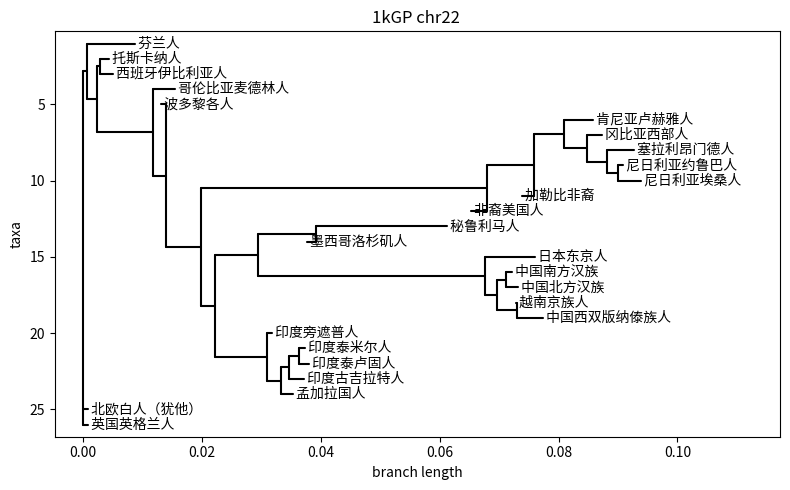

In [6]:
from matplotlib import font_manager
font_path = "/home/qmtang/.fonts/NotoSansCJKsc-Regular.otf"          # 刚下载的文件
font_manager.fontManager.addfont(font_path)      # 动态注册
plt.rcParams['font.family'] = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
Phylo.draw(
    tree,
    axes=ax,
    do_show=False,
    label_func=lambda clade: pop_chn.get(clade.name, "") if clade.is_terminal() else None,
    branch_labels=None                                            # 不显示分支长度
)
ax.set_title("1kGP chr22 ")
plt.tight_layout()
# plt.savefig("pop_nj_biopylo.png", dpi=300)
plt.show()

# 3. 分割样本

In [9]:
minor_pop_list = ['CDX','BEB','ASW']
print("Minor pops to exclude:", minor_pop_list)

Minor pops to exclude: ['CDX', 'BEB', 'ASW']


In [10]:
# 7. 将样本分为 major 和 minor
# 只保留 VCF 里确实存在的个体
major_samples = ped_df[
    (~ped_df['Population'].isin(minor_pop_list)) &
    (ped_df['Individual ID'].isin(vcf_samples))
]['Individual ID'].tolist()

minor_samples = ped_df[
    (ped_df['Population'].isin(minor_pop_list)) &
    (ped_df['Individual ID'].isin(vcf_samples))
]['Individual ID'].tolist()

print(f"VCF 真实存在：{len(vcf_samples)} 个")
print(f"Major 有效样本：{len(major_samples)} 个")
print(f"Minor 有效样本：{len(minor_samples)} 个")

random.seed(42)

n_minor = len(minor_samples)
n_10pct = max(1, int(n_minor * 0.1))          # 10 %
n_90pct = n_minor - n_10pct                   # 剩余 90 %

shuffled = random.sample(minor_samples, n_minor)
minor_10pct_samples = shuffled[:n_10pct]
minor_90pct_samples = shuffled[n_10pct:]

print(f"Minor 10%子集：{n_10pct} 个，90%子集：{n_90pct} 个")
minor_10pct_df = pd.DataFrame({'Individual ID': minor_10pct_samples})

# 2. 取出 ped_df 里需要的两列，避免整表 merge
pop_map = ped_df[['Individual ID', 'Population']].drop_duplicates()

# 3. 关联拿到 Population
minor_10pct_with_pop = minor_10pct_df.merge(pop_map, on='Individual ID', how='left')

# 4. 计数并展示
pop_counts = (minor_10pct_with_pop
              .groupby('Population')
              .size()
              .sort_values(ascending=False)
              .rename('count'))

print('minor_10pct_samples 中各 Population 的样本量：')
print(pop_counts)

VCF 真实存在：3202 个
Major 有效样本：2904 个
Minor 有效样本：298 个
Minor 10%子集：29 个，90%子集：269 个
minor_10pct_samples 中各 Population 的样本量：
Population
BEB    11
ASW    10
CDX     8
Name: count, dtype: int64


# 4. 1kGP 分割并计算演化矩阵

In [12]:
# %% 3. 写入三份样本列表
major_list      = os.path.join(save_dir, "pretrain", "major_samples.txt")
minor_10pct_list= os.path.join(save_dir, "finetune", "minor_10pct.samples.txt")
minor_90pct_list= os.path.join(save_dir, "impute_out", "minor_90pct.samples.txt")

with open(major_list, 'w') as f:
    for sid in major_samples:
        f.write(sid + '\n')

with open(minor_10pct_list, 'w') as f:
    for sid in minor_10pct_samples:
        f.write(sid + '\n')

with open(minor_90pct_list, 'w') as f:
    for sid in minor_90pct_samples:
        f.write(sid + '\n')

# %% 4. 定义输出 VCF 路径
major_vcf_path      = os.path.join(save_dir, "pretrain", "major_pops.vcf.gz") 
minor_10pct_vcf_path= os.path.join(save_dir, "finetune", "minor_pops.10pct.vcf.gz")
minor_90pct_vcf_path= os.path.join(save_dir, "impute_out", "minor_pops.90pct.vcf.gz")

# %% 5. 用 bcftools 提取 子集
print(f'Generating {major_vcf_path}')
subprocess.run([
    "bcftools", "view", "-S", major_list,
    "-Oz", "-o", major_vcf_path, KGP_vcf
], check=True)
subprocess.run(["tabix", "-p", "vcf", major_vcf_path], check=True)

for subset_list, out_path in [(minor_10pct_list, minor_10pct_vcf_path),
                              (minor_90pct_list, minor_90pct_vcf_path)]:
    print(f'Generating {out_path}')
    subprocess.run([
        "bcftools", "view", "-S", subset_list,
        "-R", major_vcf_path,        # 保证位点与 major 完全一致
        "-Oz", "-o", out_path, KGP_vcf
    ], check=True)
    # 建索引
    subprocess.run(["tabix", "-p", "vcf", out_path], check=True)

Generating /mnt/qmtang/EvoFill_data/20251121_chr22_v2/pretrain/major_pops.vcf.gz
Generating /mnt/qmtang/EvoFill_data/20251121_chr22_v2/finetune/minor_pops.10pct.vcf.gz
Generating /mnt/qmtang/EvoFill_data/20251121_chr22_v2/impute_out/minor_pops.90pct.vcf.gz


In [13]:
# %% 6. 计算 major 遗传距离矩阵（如已算过可跳过）
evo_mat_major = os.path.join(save_dir, "pretrain", "evo_mat_major_pops.tsv")
subprocess.run([VCF2DIS, "-InPut", major_vcf_path, "-OutPut", evo_mat_major], check=True)
# 对称化
dist = pd.read_csv(evo_mat_major, sep='\t', index_col=0, skiprows=1, header=None)
idx  = [i.strip() for i in dist.index]
dist.columns, dist.index = idx, idx
dist.to_csv(evo_mat_major, sep='\t', header=True, index=True)

Total Sample Number to construct p-distance matrix is [ 2904 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...
	Rscript	vistreecode.r	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/pretrain/evo_mat_major_pops.tsv
	or see more at
		[ https://github.com/hewm2008/VCF2Dis/blob/main/OtherWay2ConstructTree.md ]	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/pretrain/evo_mat_major_pops.tsv


In [14]:
# %% 7. 计算 minor_10pct 遗传距离矩阵
evo_mat_10pct = os.path.join(save_dir, "finetune", "evo_mat_minor_pops.10pct.tsv")
subprocess.run([VCF2DIS, "-InPut", minor_10pct_vcf_path, "-OutPut", evo_mat_10pct], check=True)
# 对称化
dist_10pct = pd.read_csv(evo_mat_10pct, sep='\t', index_col=0, skiprows=1, header=None)
idx_10pct  = [i.strip() for i in dist_10pct.index]
dist_10pct.columns, dist_10pct.index = idx_10pct, idx_10pct
dist_10pct.to_csv(evo_mat_10pct, sep='\t', header=True, index=True)

Total Sample Number to construct p-distance matrix is [ 29 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...
	Rscript	vistreecode.r	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/finetune/evo_mat_minor_pops.10pct.tsv
	or see more at
		[ https://github.com/hewm2008/VCF2Dis/blob/main/OtherWay2ConstructTree.md ]	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/finetune/evo_mat_minor_pops.10pct.tsv


In [15]:
# 参数区
minor_vcf   = os.path.join(save_dir, "impute_out", "minor_pops.90pct.vcf.gz")
out_vcf     = os.path.join(save_dir, "impute_in",  "minor_pops.90pct.masked50p.vcf.gz") 
missing_rate = 0.50   # 位点设缺失
seed        = 42
random.seed(seed)

# 1. 创建临时未压缩文件（cyvcf2 不支持直接写 gz）
tmp = out_vcf.replace(".gz", "")

# 2. 打开 VCF 并写入
vcf = VCF(minor_vcf)
w   = Writer(tmp, vcf)

for variant in vcf:
    # 先全部取出来，改掉后再一次性写回
    gts = variant.genotypes          # list of [a1, a2, phased]
    for i in range(len(vcf.samples)):
        if random.random() < missing_rate:
            gts[i] = [-1, -1, gts[i][2]]   # 保留 phased 标志
    variant.genotypes = gts              # 关键：重新赋值，触发 cyvcf2 写入
    w.write_record(variant)

w.close(); vcf.close()

# 3. bgzip 并建立 tbi
subprocess.run(["bgzip", "-f", tmp], check=True)
subprocess.run(["tabix", "-p", "vcf", out_vcf], check=True)
# subprocess.run(["bcftools stats -s - ", out_vcf, " | grep 'Missing'"], check=True)

print(f"masked VCF saved to: {out_vcf}")

masked VCF saved to: /mnt/qmtang/EvoFill_data/20251121_chr22_v2/impute_in/minor_pops.90pct.masked50p.vcf.gz


# 5. 古DNA

In [4]:
# %% 7. 计算 minor_10pct 遗传距离矩阵
aDNA_vcf = "/mnt/qmtang/EvoFill_data/20251121_chr22_v2/augment/chr22_trimmed_AADR_renamed.vcf.gz"

evo_mat_aDNA = os.path.join(save_dir, "augment", "evo_mat_aDNA.tsv")
subprocess.run([VCF2DIS, "-InPut", aDNA_vcf, "-OutPut", evo_mat_aDNA], check=True)
# 对称化
dist_aDNA = pd.read_csv(evo_mat_aDNA, sep='\t', index_col=0, skiprows=1, header=None)
idx_aDNA  = [i.strip() for i in dist_aDNA.index]
dist_aDNA.columns, dist_aDNA.index = idx_aDNA, idx_aDNA
dist_aDNA.to_csv(evo_mat_aDNA, sep='\t', header=True, index=True)
dist_aDNA

Total Sample Number to construct p-distance matrix is [ 2000 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...
	Rscript	vistreecode.r	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/augment/evo_mat_aDNA.tsv
	or see more at
		[ https://github.com/hewm2008/VCF2Dis/blob/main/OtherWay2ConstructTree.md ]	/mnt/qmtang/EvoFill_data/20251121_chr22_v2/augment/evo_mat_aDNA.tsv


,AADR00001,AADR00002,AADR00003,AADR00004,AADR00005,AADR00006,AADR00007,AADR00008,AADR00009,AADR00010,...,AADR01991,AADR01992,AADR01993,AADR01994,AADR01995,AADR01996,AADR01997,AADR01998,AADR01999,AADR02000
AADR00001,0.000000,0.291670,0.288188,0.287662,0.298471,0.297100,0.285423,0.288084,0.298591,0.286386,...,0.291376,0.281310,0.287788,0.273282,0.288032,0.287877,0.281938,0.298756,0.286050,0.298417
AADR00002,0.291670,0.000000,0.283169,0.240446,0.238844,0.292367,0.290746,0.293325,0.291281,0.278917,...,0.280289,0.289122,0.222195,0.282277,0.277553,0.302862,0.284066,0.304702,0.280514,0.280554
AADR00003,0.288188,0.283169,0.000000,0.301451,0.307293,0.293335,0.275401,0.294270,0.284944,0.277591,...,0.292489,0.278486,0.285207,0.274809,0.291430,0.297402,0.282010,0.300550,0.285356,0.294300
AADR00004,0.287662,0.240446,0.301451,0.000000,0.250667,0.307880,0.299278,0.297976,0.309351,0.290435,...,0.266373,0.303381,0.245209,0.288864,0.270688,0.305840,0.293413,0.307441,0.270692,0.261684
AADR00005,0.298471,0.238844,0.307293,0.250667,0.000000,0.285979,0.286046,0.295009,0.287900,0.296462,...,0.279810,0.272542,0.238318,0.281954,0.287849,0.295445,0.279773,0.304940,0.285976,0.300071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AADR01996,0.287877,0.302862,0.297402,0.305840,0.295445,0.302767,0.285587,0.298733,0.287470,0.299464,...,0.296191,0.283828,0.297397,0.284718,0.305801,0.000000,0.294788,0.275776,0.300157,0.306820
AADR01997,0.281938,0.284066,0.282010,0.293413,0.279773,0.289113,0.292478,0.287632,0.294211,0.283844,...,0.294512,0.268734,0.285649,0.263846,0.291950,0.294788,0.000000,0.293638,0.289306,0.291213
AADR01998,0.298756,0.304702,0.300550,0.307441,0.304940,0.296018,0.289548,0.305122,0.286301,0.294147,...,0.301905,0.300147,0.310357,0.298603,0.307068,0.275776,0.293638,0.000000,0.304850,0.306187
AADR01999,0.286050,0.280514,0.285356,0.270692,0.285976,0.300172,0.296676,0.293443,0.286991,0.279517,...,0.228364,0.261521,0.287101,0.285546,0.229311,0.300157,0.289306,0.304850,0.000000,0.220246
